<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Dataset-parsers-and-cleaning-functions" data-toc-modified-id="Dataset-parsers-and-cleaning-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset parsers and cleaning functions</a></span><ul class="toc-item"><li><span><a href="#Testing-data" data-toc-modified-id="Testing-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Testing data</a></span></li></ul></li><li><span><a href="#SSA-Decomposition-trial" data-toc-modified-id="SSA-Decomposition-trial-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SSA Decomposition trial</a></span></li><li><span><a href="#Class-implementation" data-toc-modified-id="Class-implementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Class implementation</a></span><ul class="toc-item"><li><span><a href="#L=2" data-toc-modified-id="L=2-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>L=2</a></span></li><li><span><a href="#L=5" data-toc-modified-id="L=5-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>L=5</a></span></li><li><span><a href="#L=20" data-toc-modified-id="L=20-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>L=20</a></span></li><li><span><a href="#L=40" data-toc-modified-id="L=40-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>L=40</a></span></li><li><span><a href="#L=60" data-toc-modified-id="L=60-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>L=60</a></span></li><li><span><a href="#L=100" data-toc-modified-id="L=100-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>L=100</a></span></li></ul></li><li><span><a href="#Whole-column" data-toc-modified-id="Whole-column-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Whole column</a></span></li></ul></div>

# Imports

In [2]:
# Required imports
import csv
import os
import numpy as np
import pandas as pd
import gzip
import glob
import pickle
import copy
import math
from io import StringIO
import importlib.machinery
import matplotlib.pyplot as plt
random_state=10
np.random.seed(random_state)

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (20,20)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors

In [3]:
# Data location and sample user
prefix='dataset/Extrasensory_uuid_fl_uTAR/'
cross_validation_user_loc='dataset/cv_5_folds/'
# user_sample='3600D531-0C55-44A7-AE95-A7A38519464E.features_labels'
user_sample='CCAF77F0-FABB-4F2F-9E24-D56AD0C5A82F.features_labels'
done=0 # Pickled files are not created [0]

# Dataset parsers and cleaning functions

In [4]:
# Dataset parsers for header/ body for CSVs
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    
    #print("M matrix shape:",M.shape)
    #print("Matrix: ",np.argwhere(M))
    trinary_labels_mat[M]=-1 # Replace NaNs with -1.0 for which we then apply a mask
    unique,counts=np.unique(trinary_labels_mat,return_counts=True)
    print(*zip(unique,counts)) 
    
#     Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,trinary_labels_mat,M,timestamps);

def read_user_data(directory):
    print('Reading {}'.format(directory.split("/")[-1]))

    # Read the entire csv file of the user:
    with gzip.open(directory,'rb') as fid:
        csv_str = fid.read();
        csv_str = csv_str.decode("utf-8")
        pass;

    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [5]:
# Clean labels
def clean_labels(input_label):
    if label.endswith('_'):
        label=label[:-1]+')'
    label=label.replace('__',' (').replace('_',' ')
    label=label[0]+label[1:].lower()
    label=label.replace('i m','I\'m')
    return label

In [6]:
# Get a summary of the sensor feature
'''
# Summarize features as we are only using phone_acc,phone_gyro,phone_mag,phone_loc,phone_audio,
# phone_app,phone_battery,phone_use,phone_callstat,phone_wifi,phone_lf,phone_time
# We are ignoring the use of the smartwatch features. There are definitely features that will be used
# much more (e.g. than the phone_callstat) but we'll leave that up to the ML algorithm.
'''
def summarize_features(feature_list):
    summary_feature_list=np.empty_like(feature_list)
    for (ind,feature) in enumerate(feature_list):
        if feature.startswith('raw_acc'):
            summary_feature_list[ind]='phone_acc' 
        if feature.startswith('proc_gyro'):
            summary_feature_list[ind]='phone_gyro'
        if feature.startswith('raw_magnet'):
            summary_feature_list[ind]='phone_mag'
        if feature.startswith('watch_acc'):
            summary_feature_list[ind]='watch_acc'
        if feature.startswith('watch_heading'):
            summary_feature_list[ind]='watch_dir'
        if feature.startswith('location'):
            summary_feature_list[ind]='phone_loc'
        if feature.startswith('audio'):
            summary_feature_list[ind]='phone_audio'
        if feature.startswith('discrete:app_state'):
            summary_feature_list[ind]='phone_app'
        if feature.startswith('discrete:battery'):
            summary_feature_list[ind]='phone_battery'
        if feature.startswith('discrete:on'):
            summary_feature_list[ind]='phone_use'
        if feature.startswith('discrete:ringer'):
            summary_feature_list[ind]='phone_callstat'
        if feature.startswith('discrete:wifi'):
            summary_feature_list[ind]='phone_wifi'
        if feature.startswith('lf'):
            summary_feature_list[ind]='phone_lf'
        if feature.startswith('discrete:time'):
            summary_feature_list[ind]='phone_time'

    return summary_feature_list


# Get a summary of the sensor feature along with the original label that was used
def summarize_features_wordy(feature_list):
    summary_feature_list=np.empty((len(feature_list),2),dtype=object)
    
    for (ind,feature) in enumerate(feature_list):
        if feature.startswith('raw_acc'):
            summary_feature_list[ind,0]='phone_acc'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('proc_gyro'):
            summary_feature_list[ind,0]='phone_gyro'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('raw_magnet'):
            summary_feature_list[ind,0]='phone_mag'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('watch_acc'):
            summary_feature_list[ind,0]='watch_acc'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('watch_heading'):
            summary_feature_list[ind,0]='watch_dir'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('location'):
            summary_feature_list[ind,0]='phone_loc'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('audio'):
            summary_feature_list[ind,0]='phone_audio'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:app_state'):
            summary_feature_list[ind,0]='phone_app'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:battery'):
            summary_feature_list[ind,0]='phone_battery'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:on'):
            summary_feature_list[ind,0]='phone_use'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:ringer'):
            summary_feature_list[ind,0]='phone_callstat'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:wifi'):
            summary_feature_list[ind,0]='phone_wifi'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('lf'):
            summary_feature_list[ind,0]='phone_lf'
            summary_feature_list[ind,1]=feature
            
        if feature.startswith('discrete:time'):
            summary_feature_list[ind,0]='phone_time'
            summary_feature_list[ind,1]=feature

    return summary_feature_list

In [7]:
# Custom dictionary class with help for duplicate keys
class Customdictionary(dict):
    def __setitem__(self,key,value):
        try:
            self[key]
        except KeyError:
            super(Customdictionary,self).__setitem__(key,[])
        self[key].append(value)

In [8]:
# Returns a standardized (0 mean, 1 variance) dataset
def standardize(X_train):
    mean=np.nanmean(X_train,axis=0).reshape((1,-1))# Ignores NaNs while finding the mean across rows
    standard_dev=np.nanstd(X_train,axis=0) # Ignores NaNs while finding the standard deviation across rows
    standard_dev_nonzero=np.where(standard_dev>0,standard_dev,1.).reshape((1,-1)) # Div zero
    
    X=(X_train-mean)/standard_dev_nonzero
    return X,mean,standard_dev_nonzero   

In [9]:
# 2D plot
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

## Testing data

In [10]:
# Reading sample data
sample_loc='{}/{}.csv.gz'.format(prefix,user_sample)
x_user,y_user,missedlabel_user,tstamp_user,featurename_user,labelname_user=read_user_data(sample_loc)

# Dataset summaries for this user
print('Data shape input for user (Len minutes/num examples, num sensors): ',x_user.shape) # Timestep examples, number of sensors
print('Label shape for user (Len minutes, num labels): ',y_user.shape,'\n') # Timestep examples, labels

countlabels_user=np.sum(y_user,axis=0) # Column summary
labelname_countlabel_user=zip(labelname_user,countlabels_user) # Zip together names, counts
labelname_countlabel_user=sorted(labelname_countlabel_user,key=lambda row:row[-1],reverse=True)

print('Sensor feature names:\n')
feature_names=summarize_features(featurename_user)
    
# for i,sensor_feature in enumerate(featurename_user):
#     print('{} :: {} ::--> {}\n'.format(i,feature_names[i],sensor_feature))

print('Activities and counts:')
print(labelname_countlabel_user)

Reading CCAF77F0-FABB-4F2F-9E24-D56AD0C5A82F.features_labels.csv.gz
(-1.0, 215586) (0.0, 177334) (1.0, 39152)
Data shape input for user (Len minutes/num examples, num sensors):  (8472, 225)
Label shape for user (Len minutes, num labels):  (8472, 51) 

Sensor feature names:

Activities and counts:
[('OR_indoors', 6395.0), ('LOC_home', 5816.0), ('PHONE_ON_TABLE', 4734.0), ('SITTING', 4152.0), ('SLEEPING', 3062.0), ('LYING_DOWN', 2727.0), ('COMPUTER_WORK', 2268.0), ('AT_SCHOOL', 980.0), ('PHONE_IN_POCKET', 297.0), ('IN_CLASS', 290.0), ('SURFING_THE_INTERNET', 188.0), ('LAB_WORK', 154.0), ('TALKING', 120.0), ('LOC_beach', 15.0), ('FIX_walking', -98.0), ('DRIVE_-_I_M_THE_DRIVER', -155.0), ('EATING', -221.0), ('OR_standing', -244.0), ('FIX_restaurant', -282.0), ('DRESSING', -343.0), ('GROOMING', -349.0), ('IN_A_MEETING', -366.0), ('ON_A_BUS', -370.0), ('STROLLING', -370.0), ('ELEVATOR', -370.0), ('OR_outside', -521.0), ('PHONE_IN_HAND', -615.0), ('FIX_running', -8472.0), ('BICYCLING', -8472.

# SSA Decomposition trial

In [26]:
temp_df=pd.DataFrame(x_user,columns=featurename_user)
temp_col=temp_df.iloc[:,1].values
temp_col=temp_col[:1000] # Get the first 1000 entries
temp_col=np.nan_to_num(temp_col).reshape(1000,1)
N=len(temp_col)
L = 70 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([temp_col[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

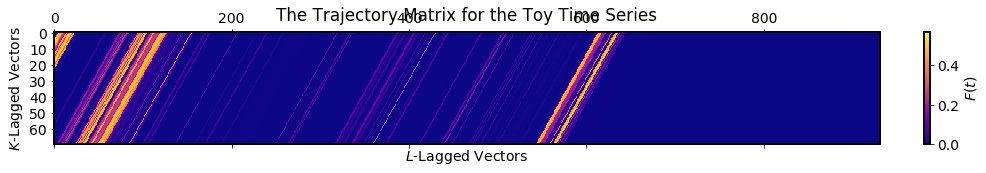

In [12]:
# plt.figure(figsize=(100,100))
ax = plt.matshow(X,aspect="auto")
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [13]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")


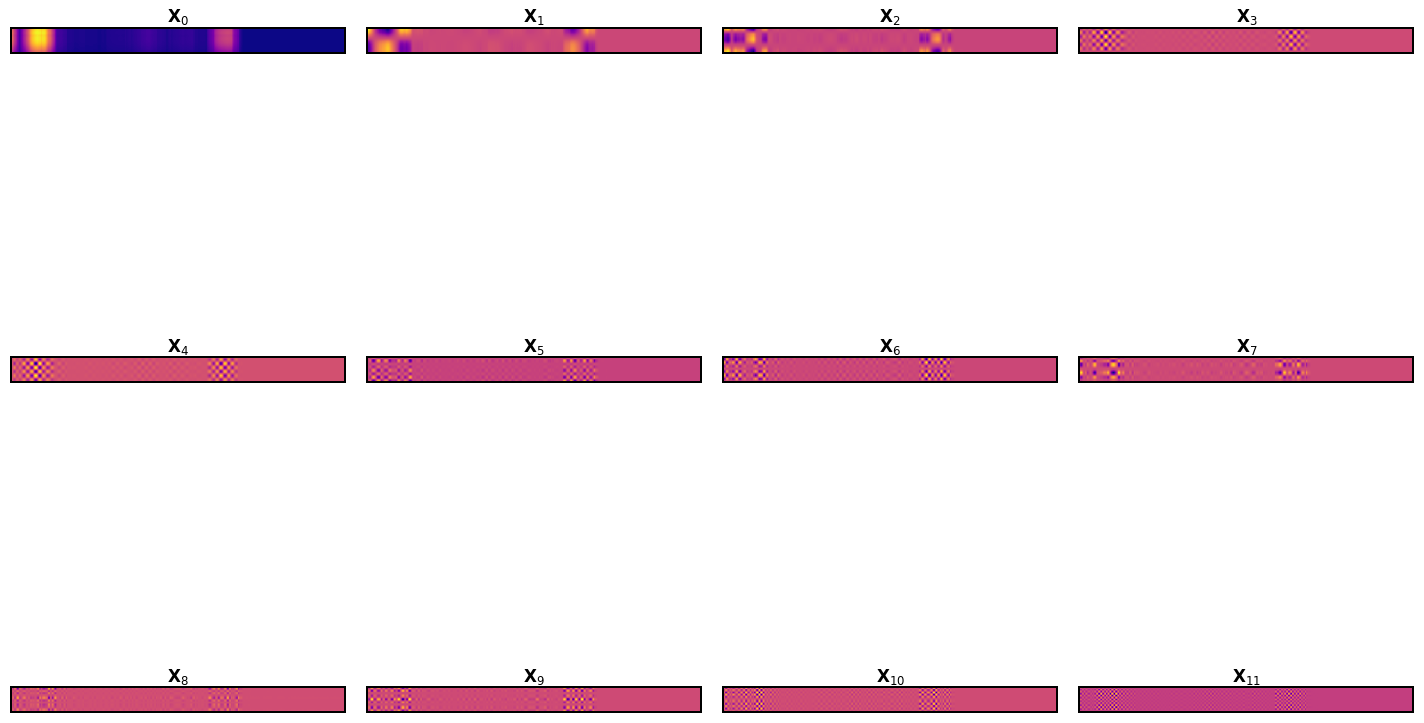

In [14]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

In [15]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX


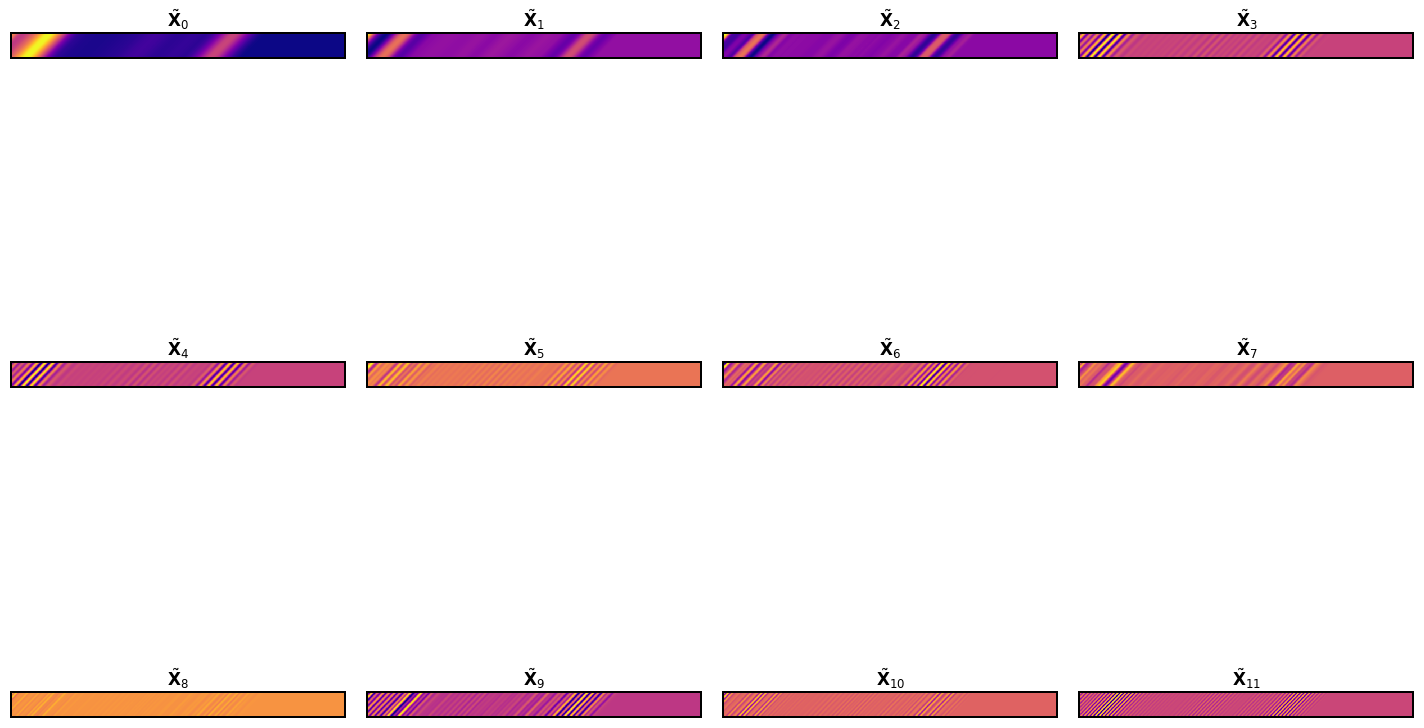

In [16]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

In [17]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

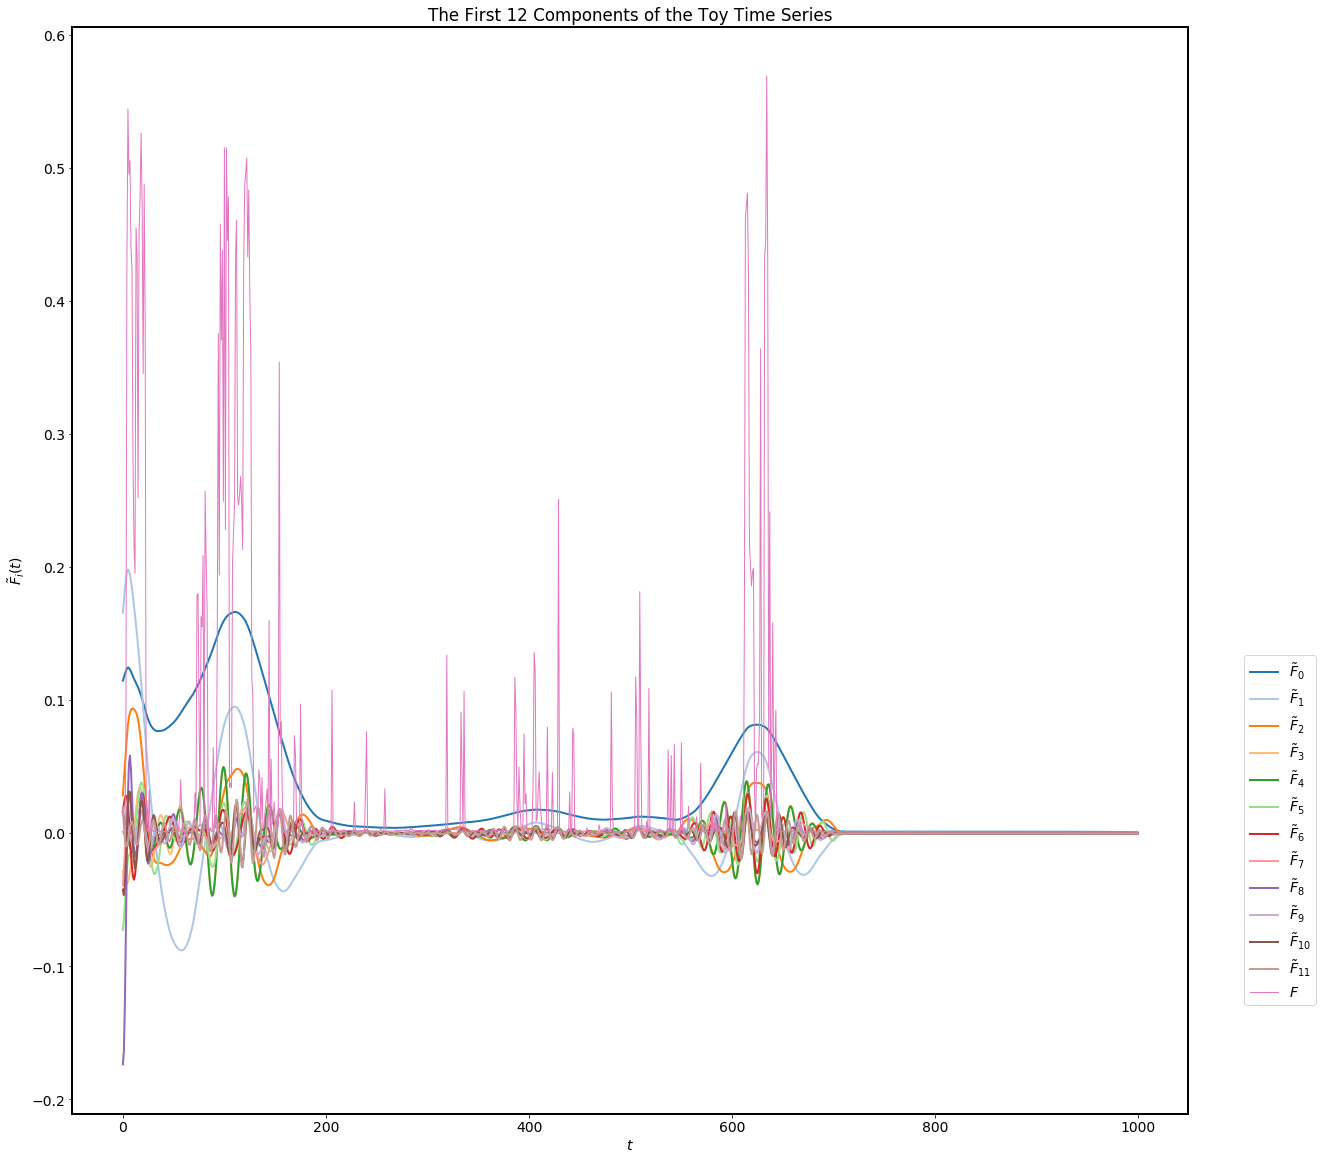

In [18]:
n = min(12,d) # In case of noiseless time series with d < 12.
t = np.arange(0,N)
# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, temp_col, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

# Class implementation

In [19]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [20]:
# temp_col,_,_=standardize(temp_col)

In [27]:
temp_col.shape

(1000, 1)

## L=2

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

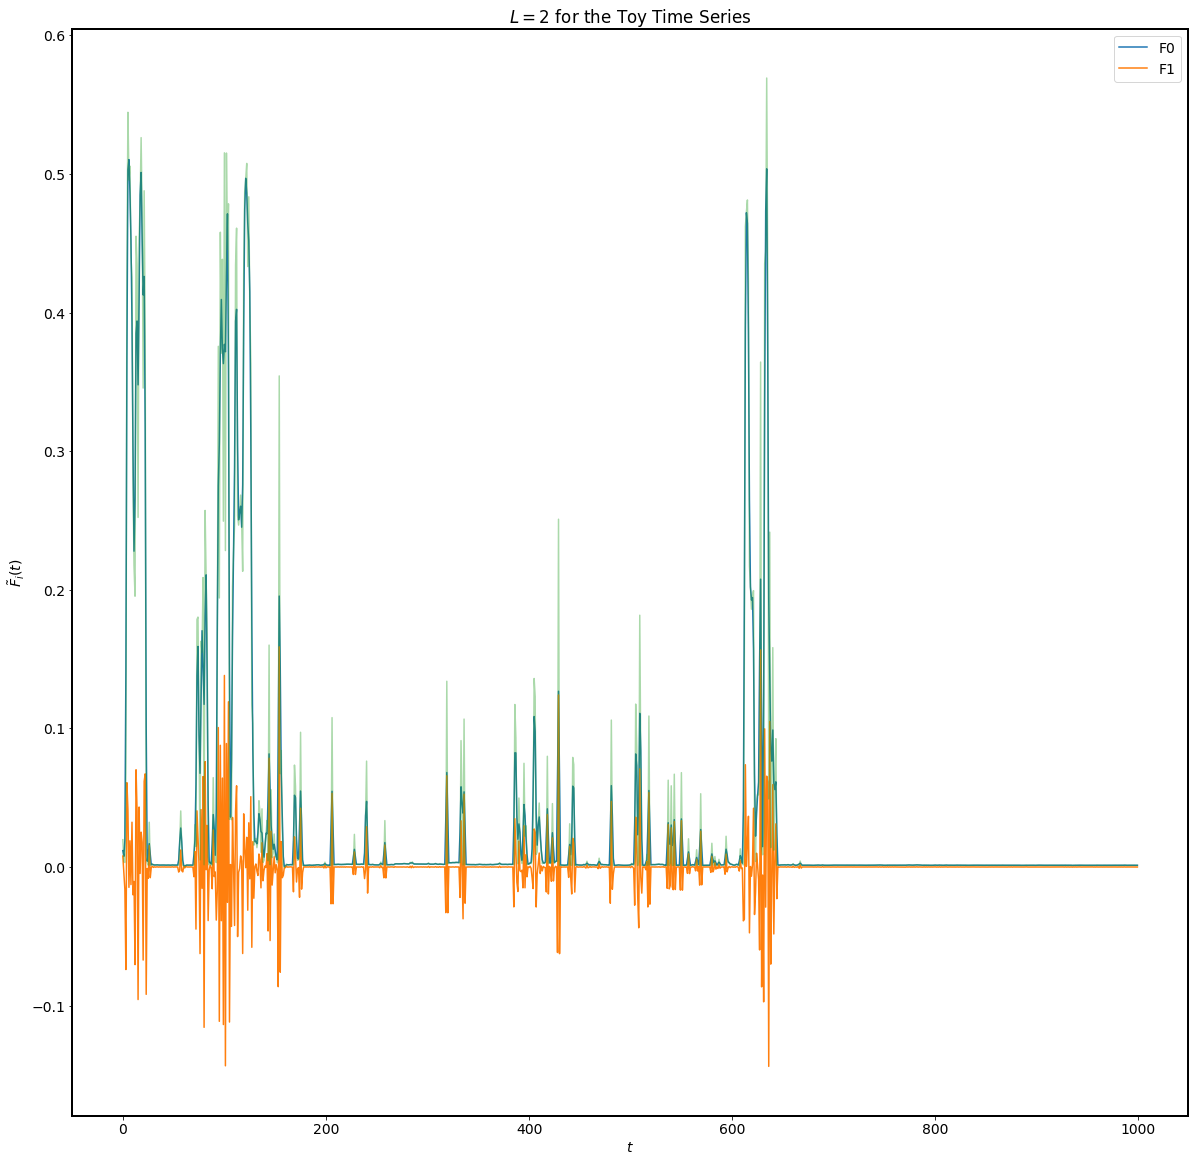

In [33]:
F_ssa_L2 = SSA(temp_col[:,0],2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

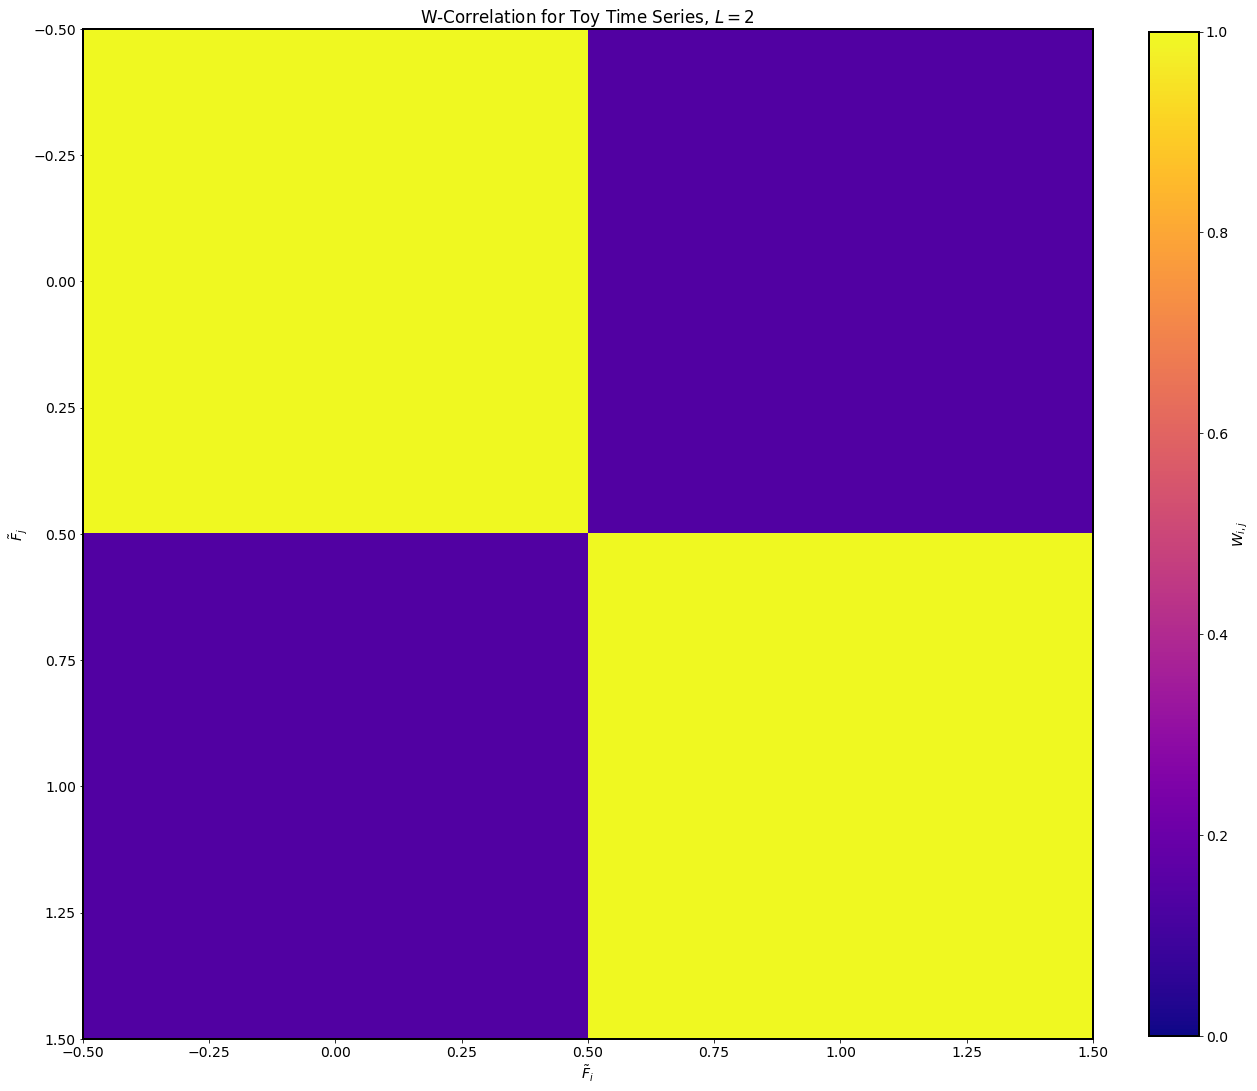

In [34]:
F_ssa_L2.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=2$");

## L=5

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

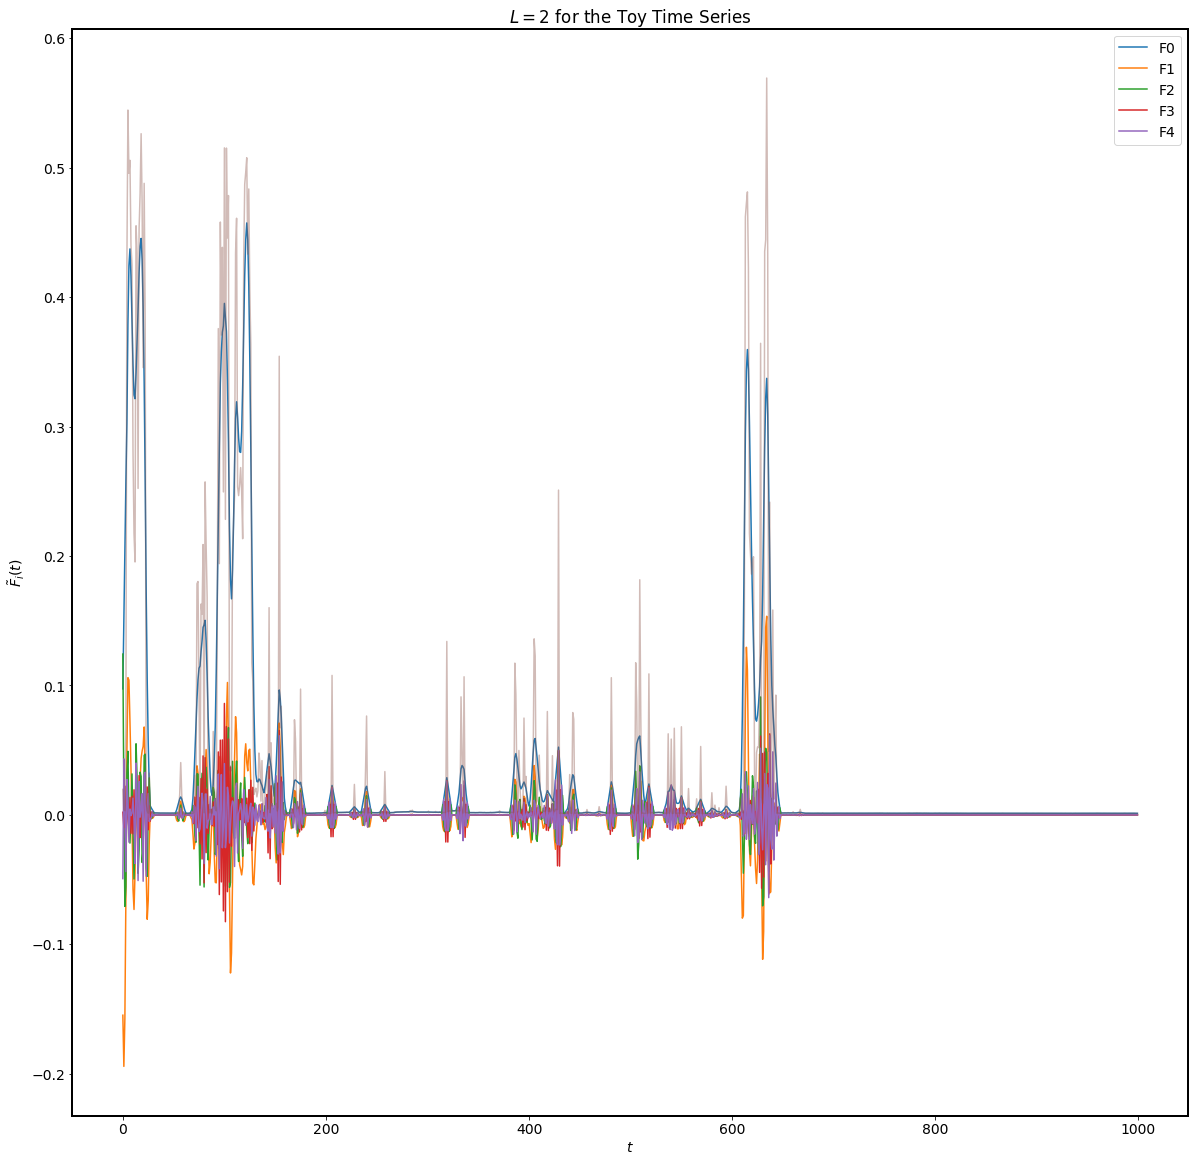

In [35]:
F_ssa_L5 = SSA(temp_col[:,0],5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

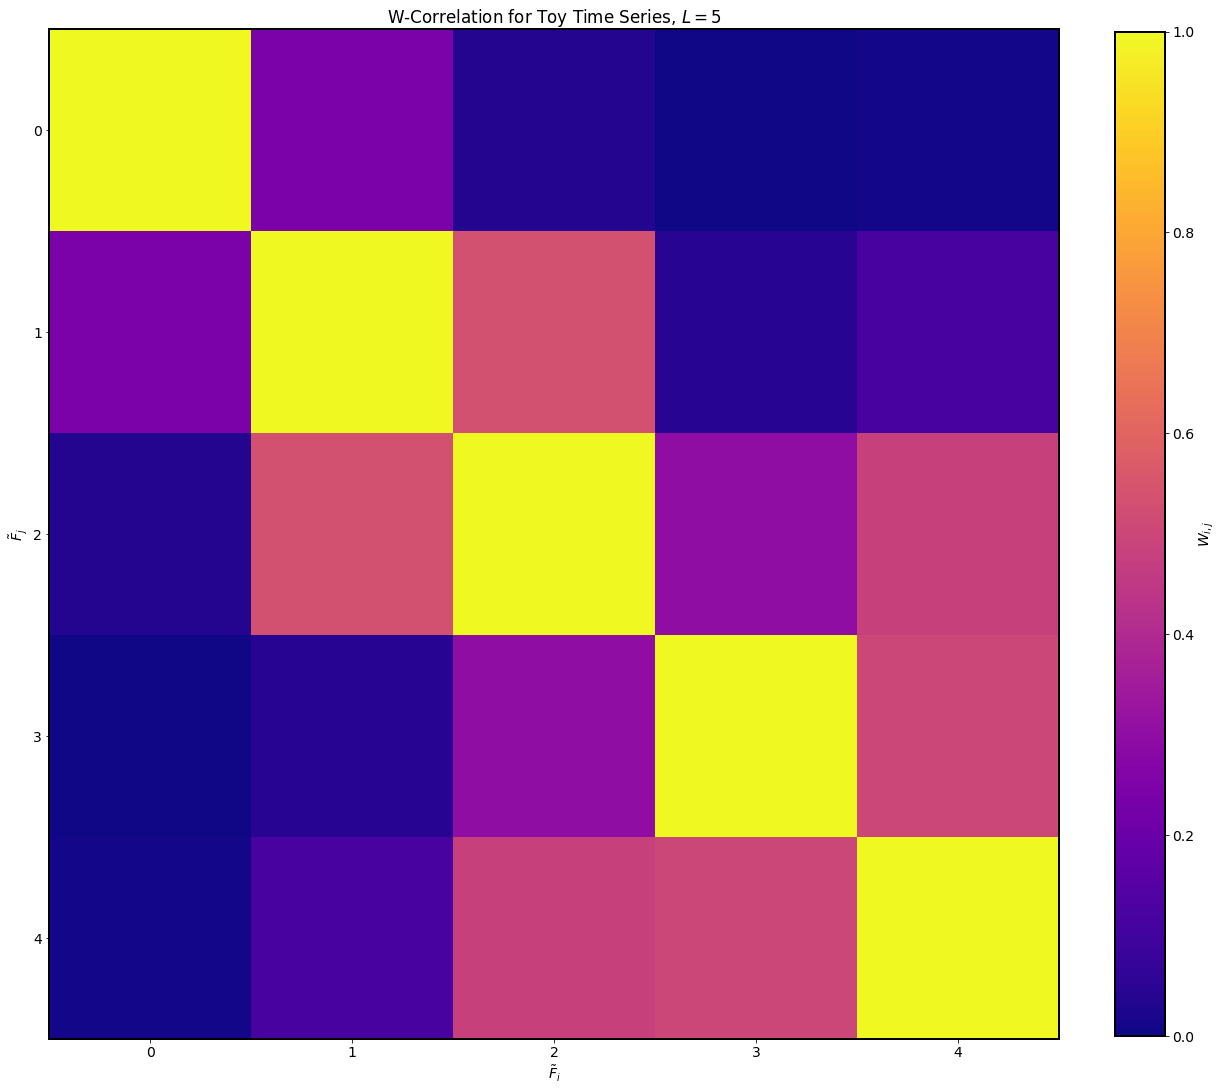

In [36]:
F_ssa_L5.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=5$");

## L=20

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

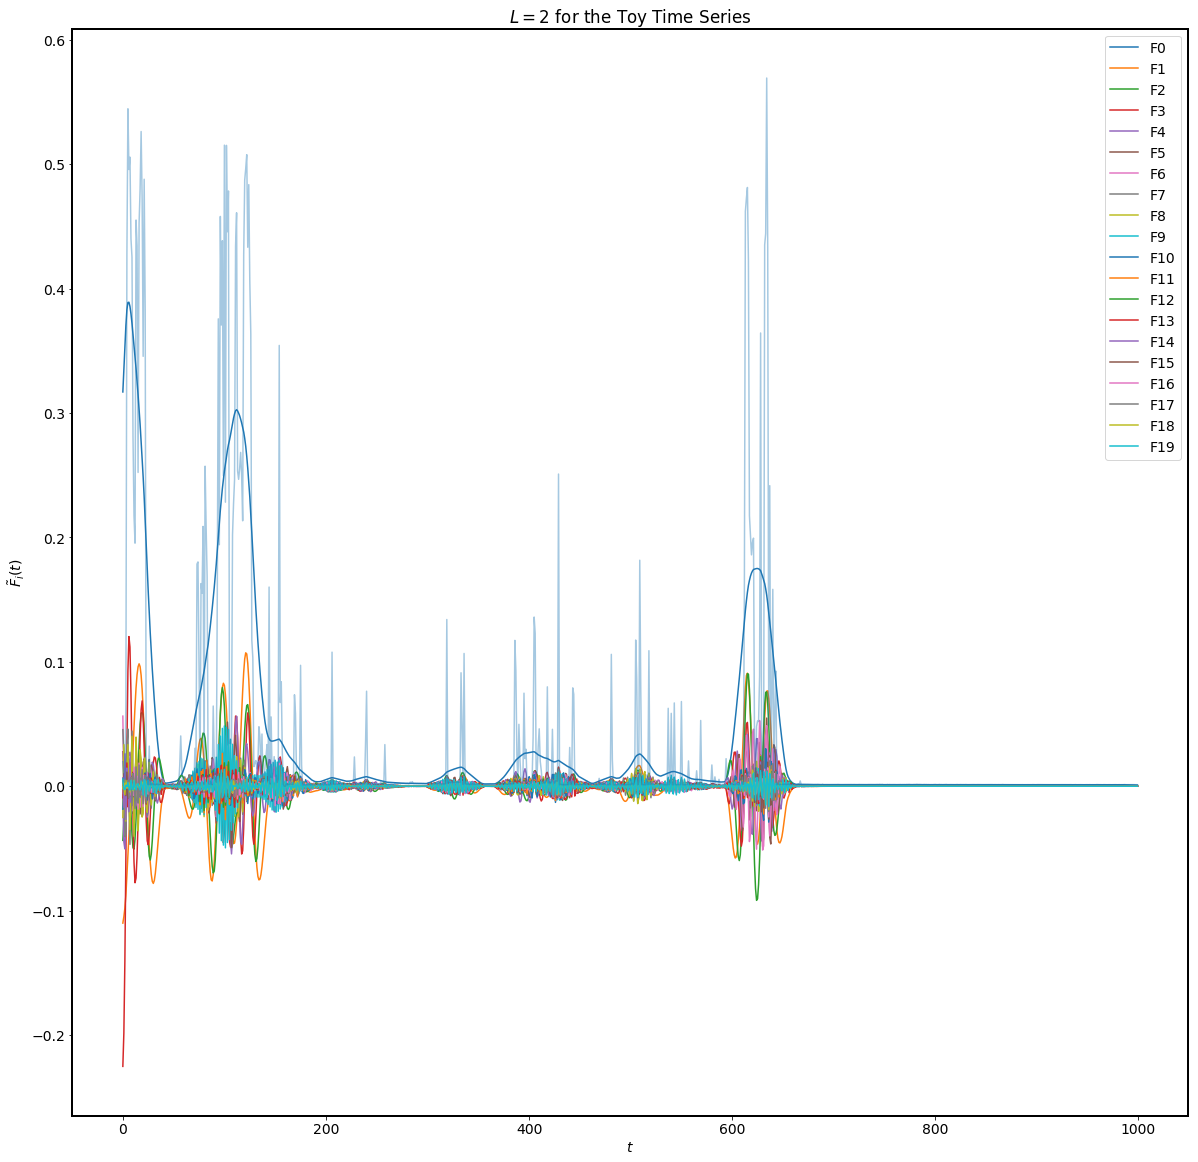

In [37]:
F_ssa_L20 = SSA(temp_col[:,0],20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=20$')

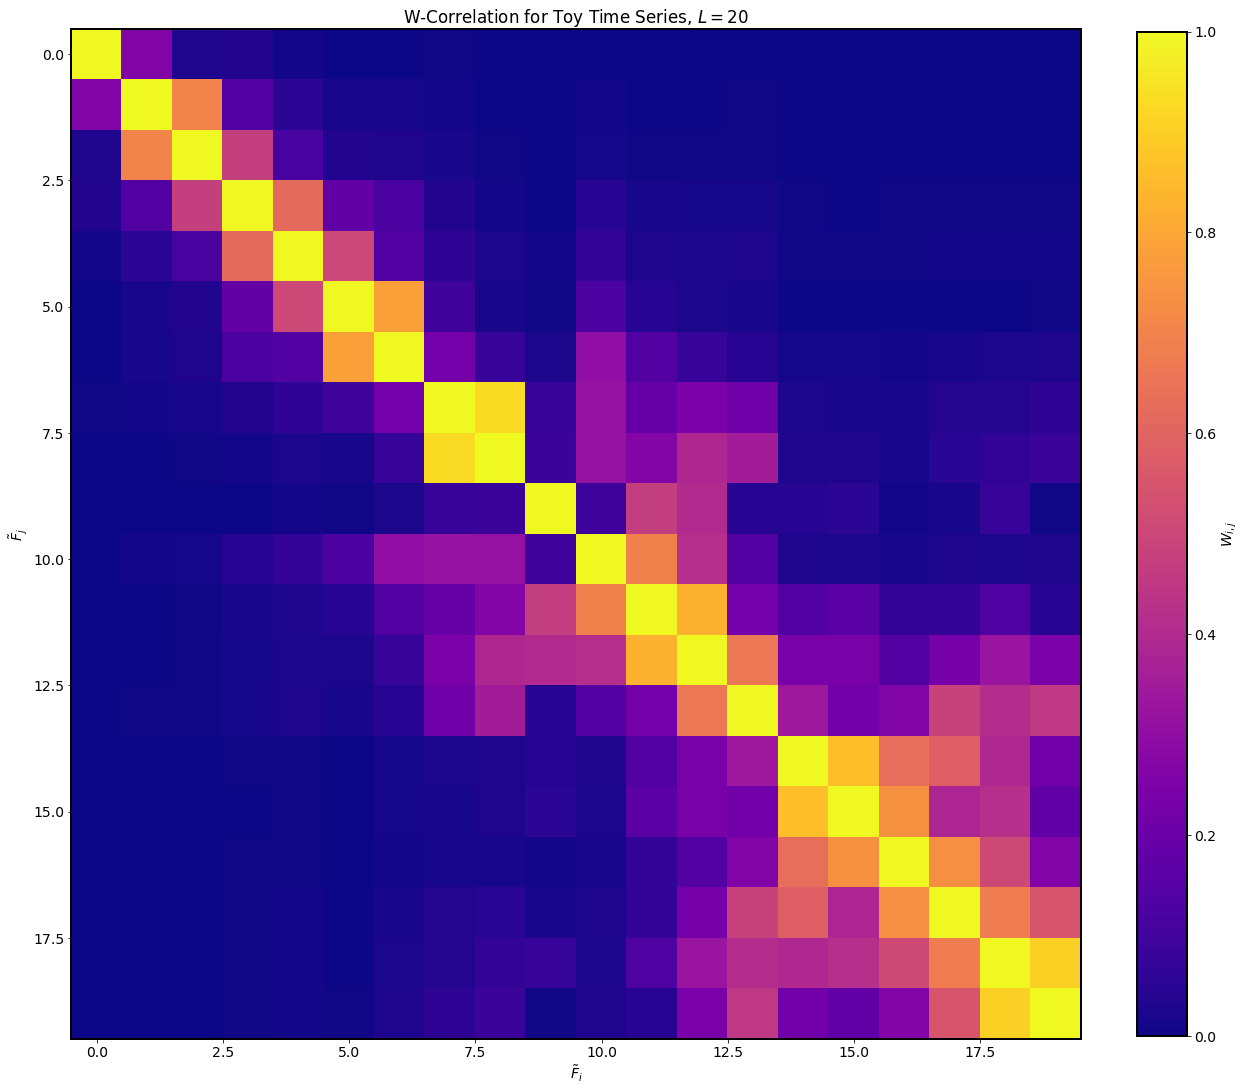

In [38]:
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$")

## L=40

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

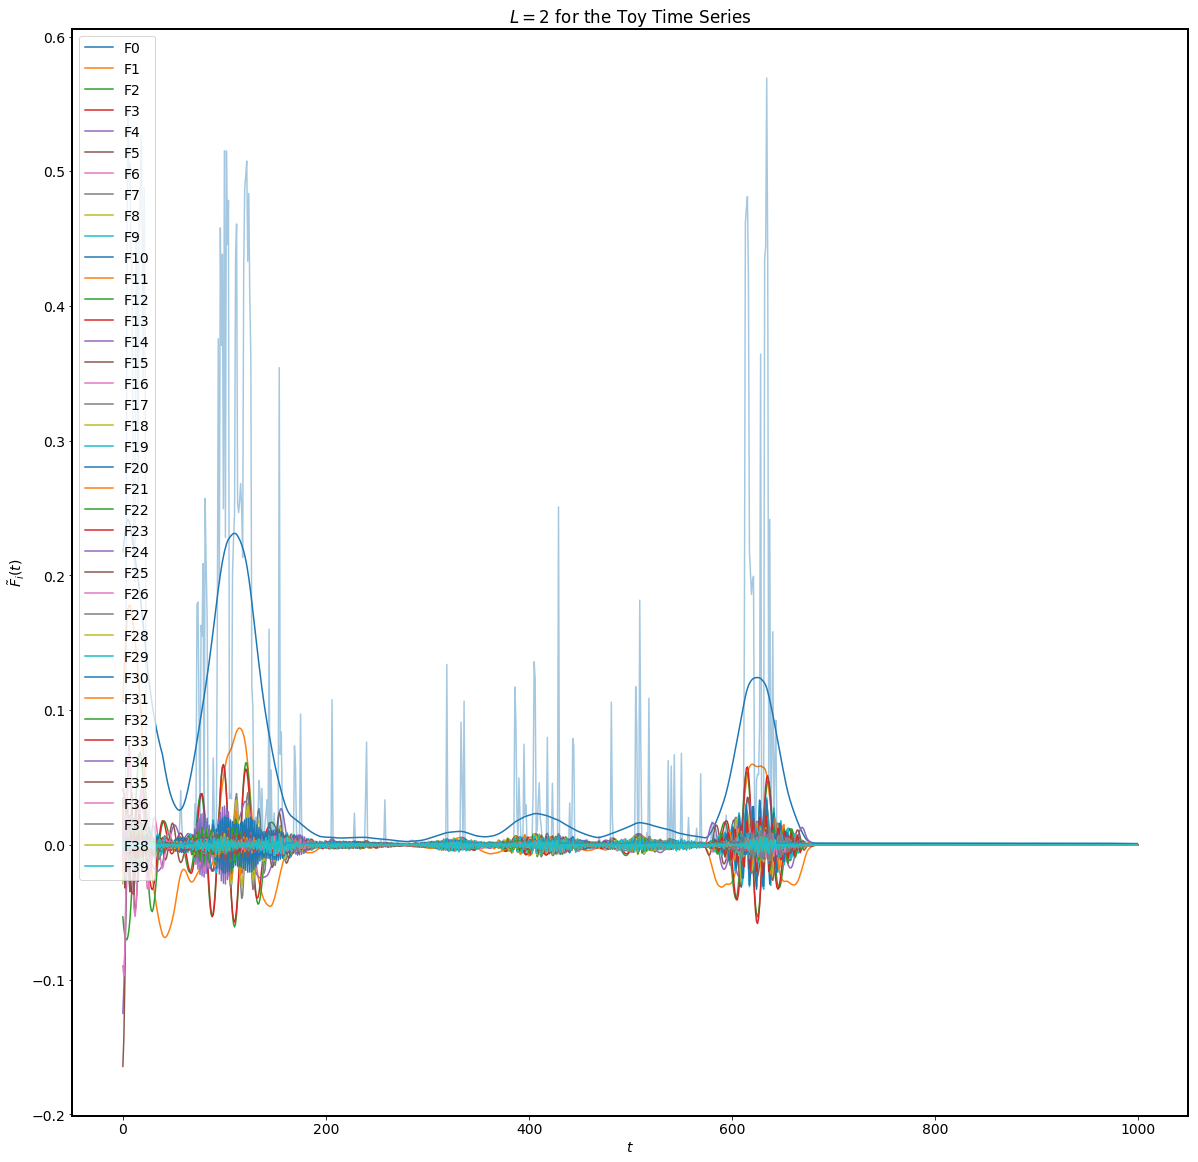

In [39]:
F_ssa_L40 = SSA(temp_col[:,0],40)
F_ssa_L40.components_to_df().plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=40$')

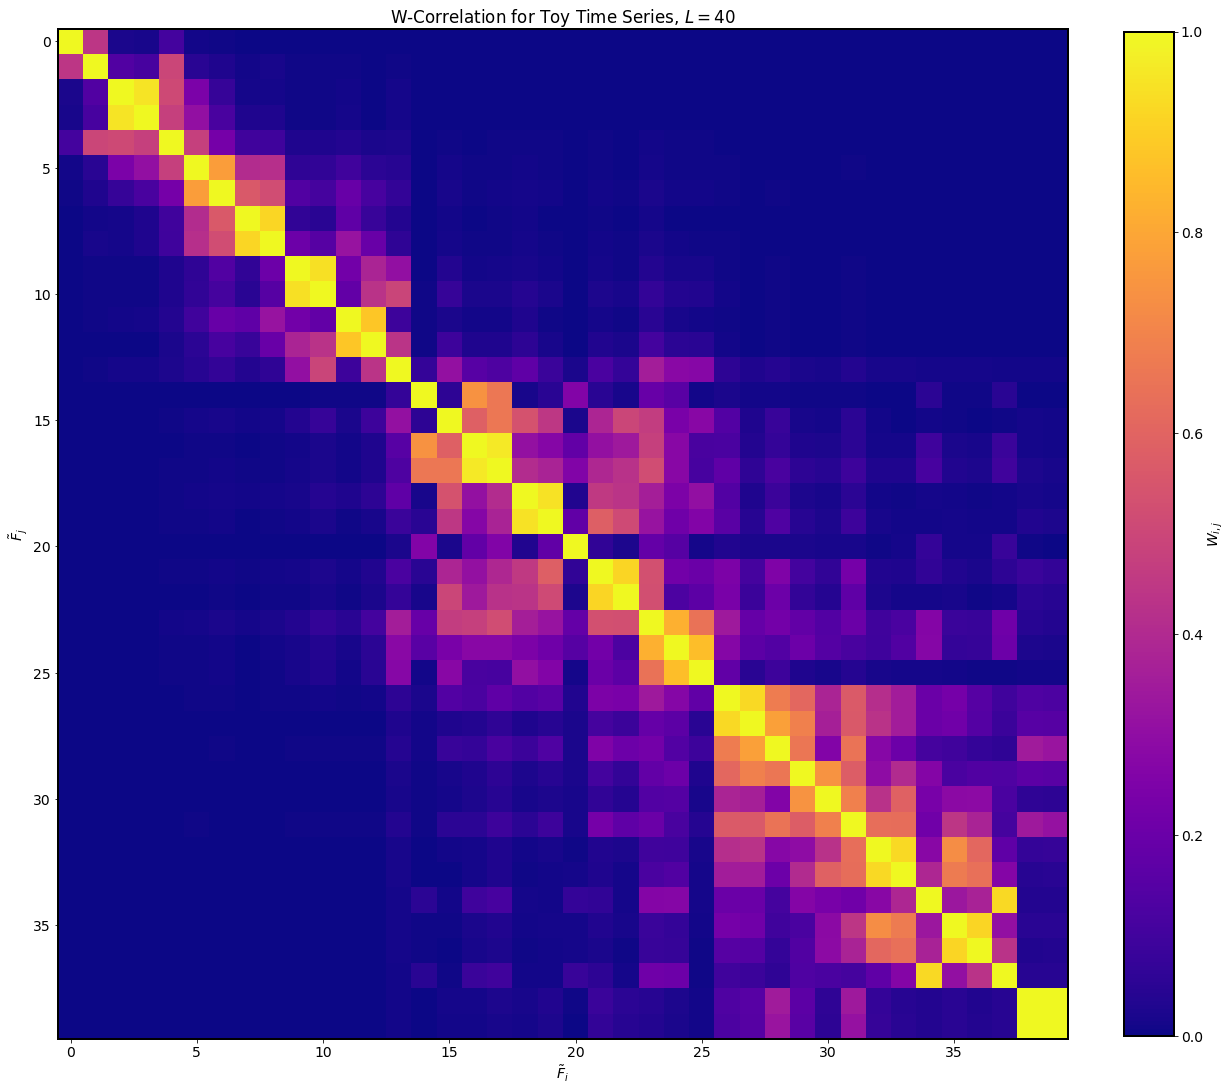

In [40]:
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$")

## L=60

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

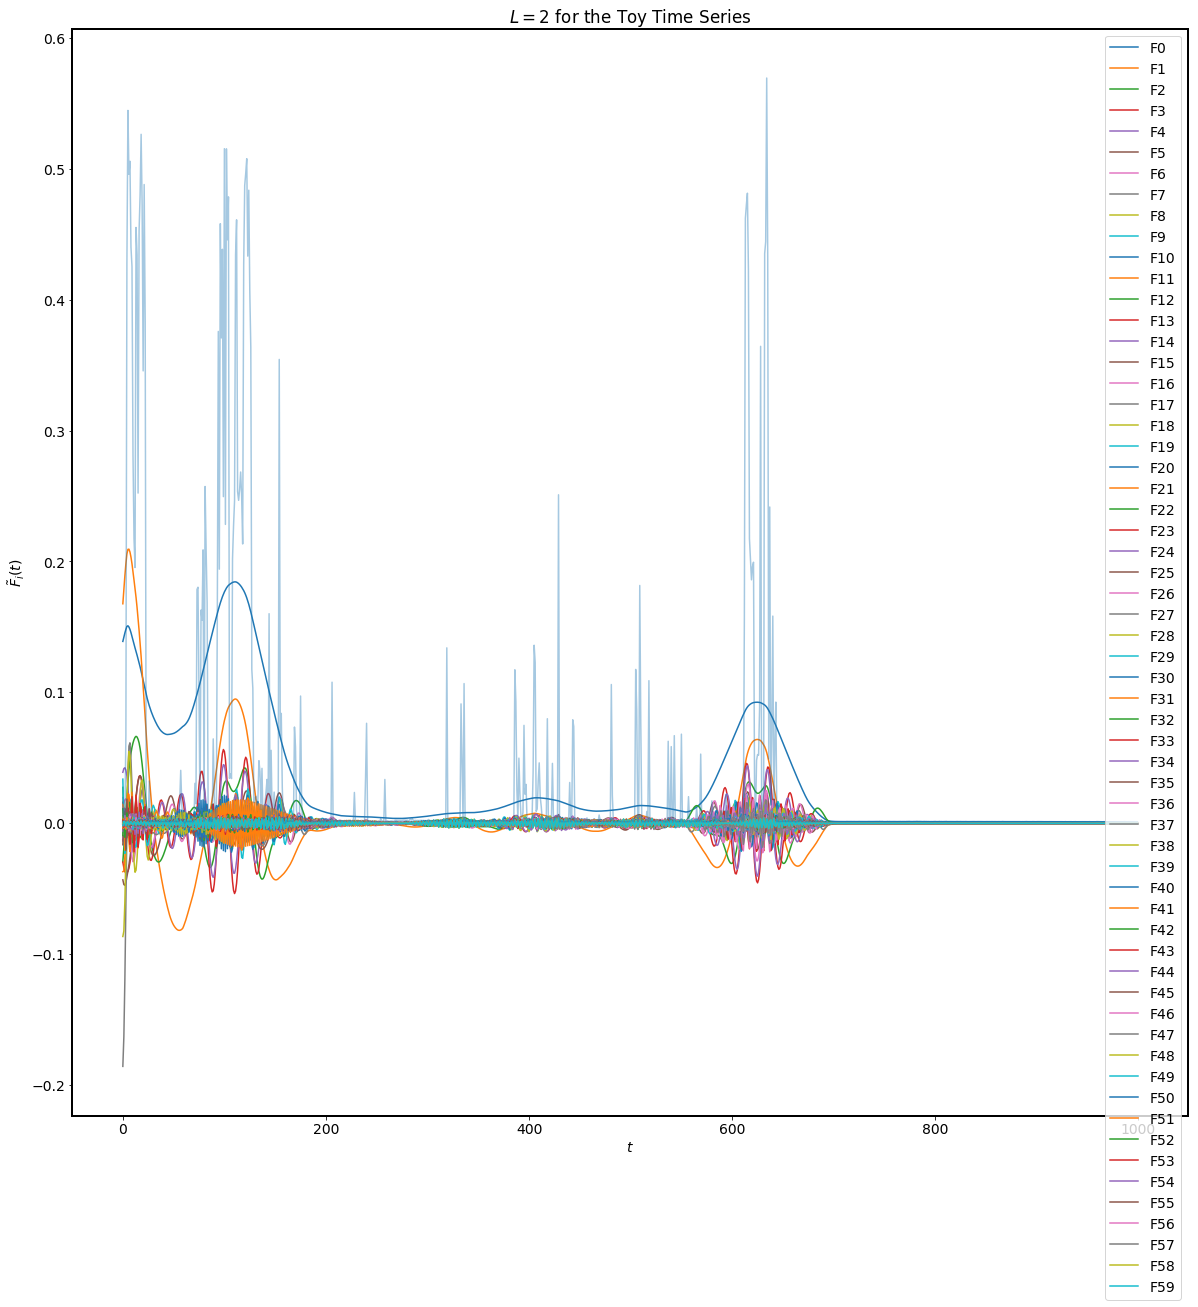

In [41]:
F_ssa_L60= SSA(temp_col[:,0],60)
F_ssa_L60.components_to_df().plot()
F_ssa_L60.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=60$')

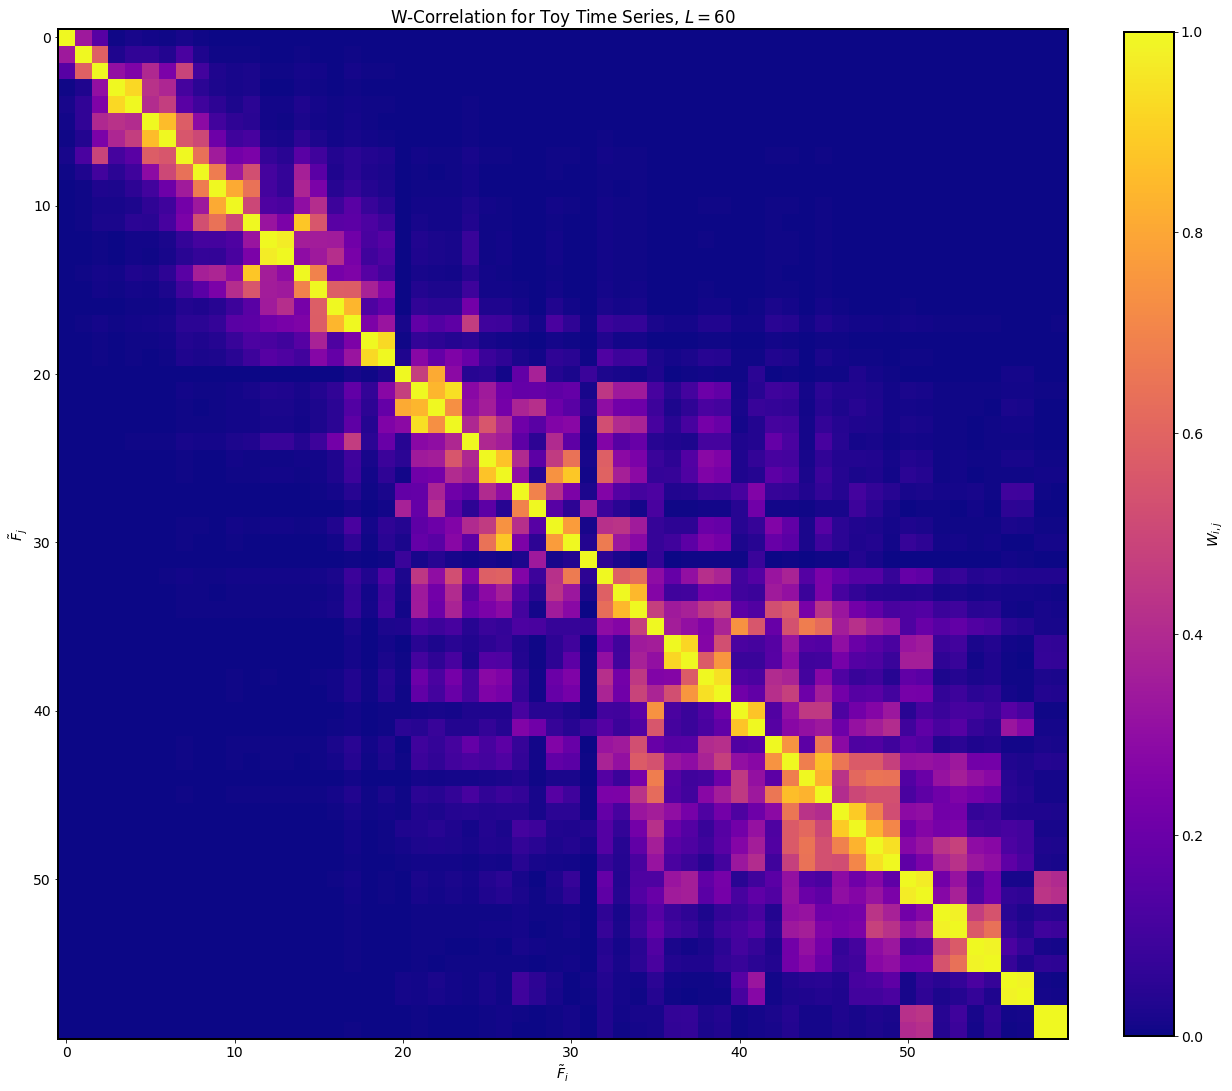

In [42]:
F_ssa_L60.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=60$")

## L=100

Text(0.5, 1.0, '$L=2$ for the Toy Time Series')

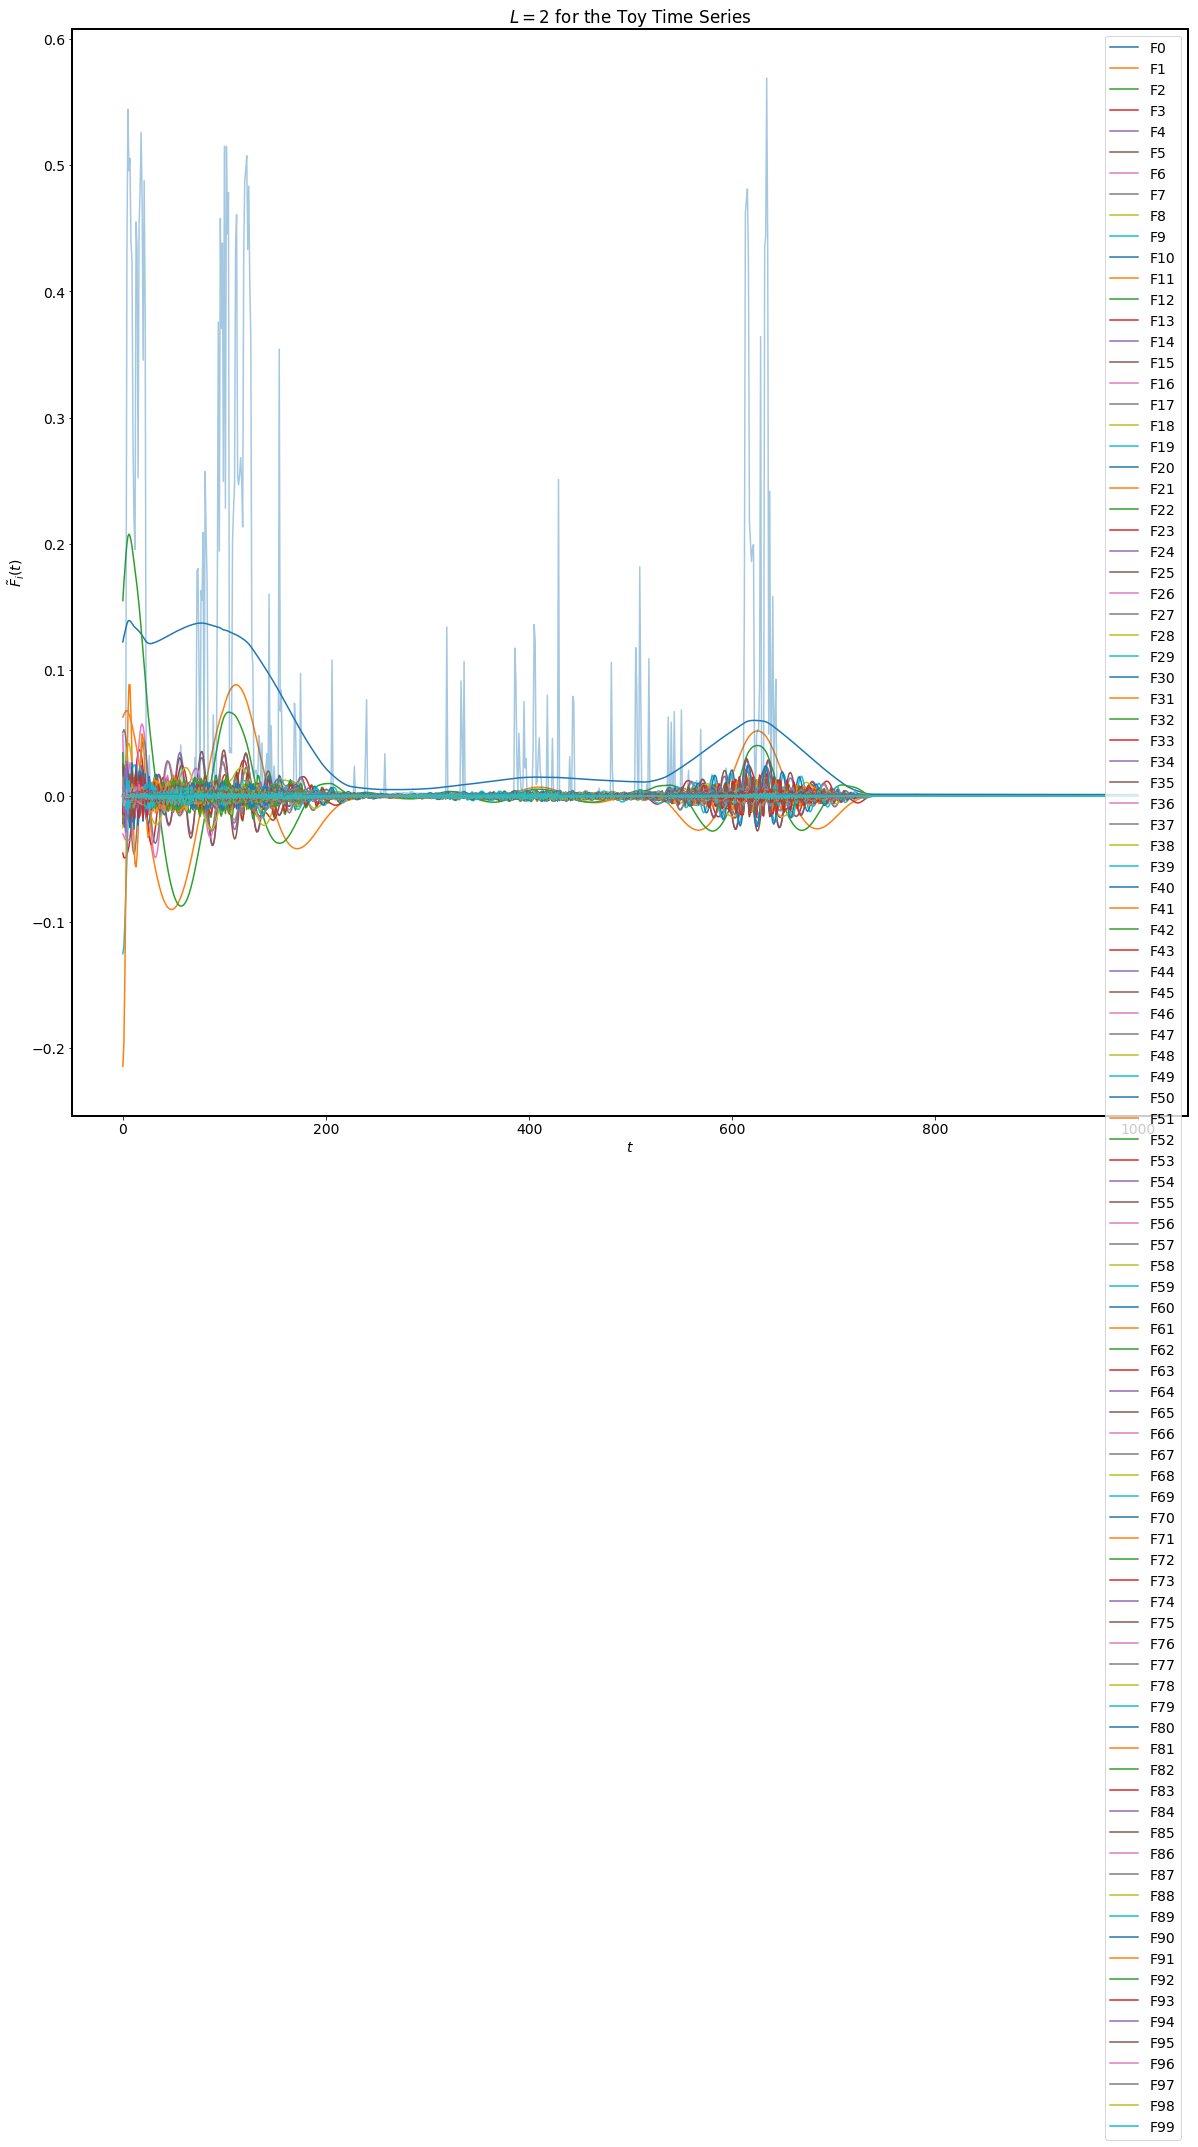

In [43]:
F_ssa_L100= SSA(temp_col[:,0],100)
F_ssa_L100.components_to_df().plot()
F_ssa_L100.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=100$')

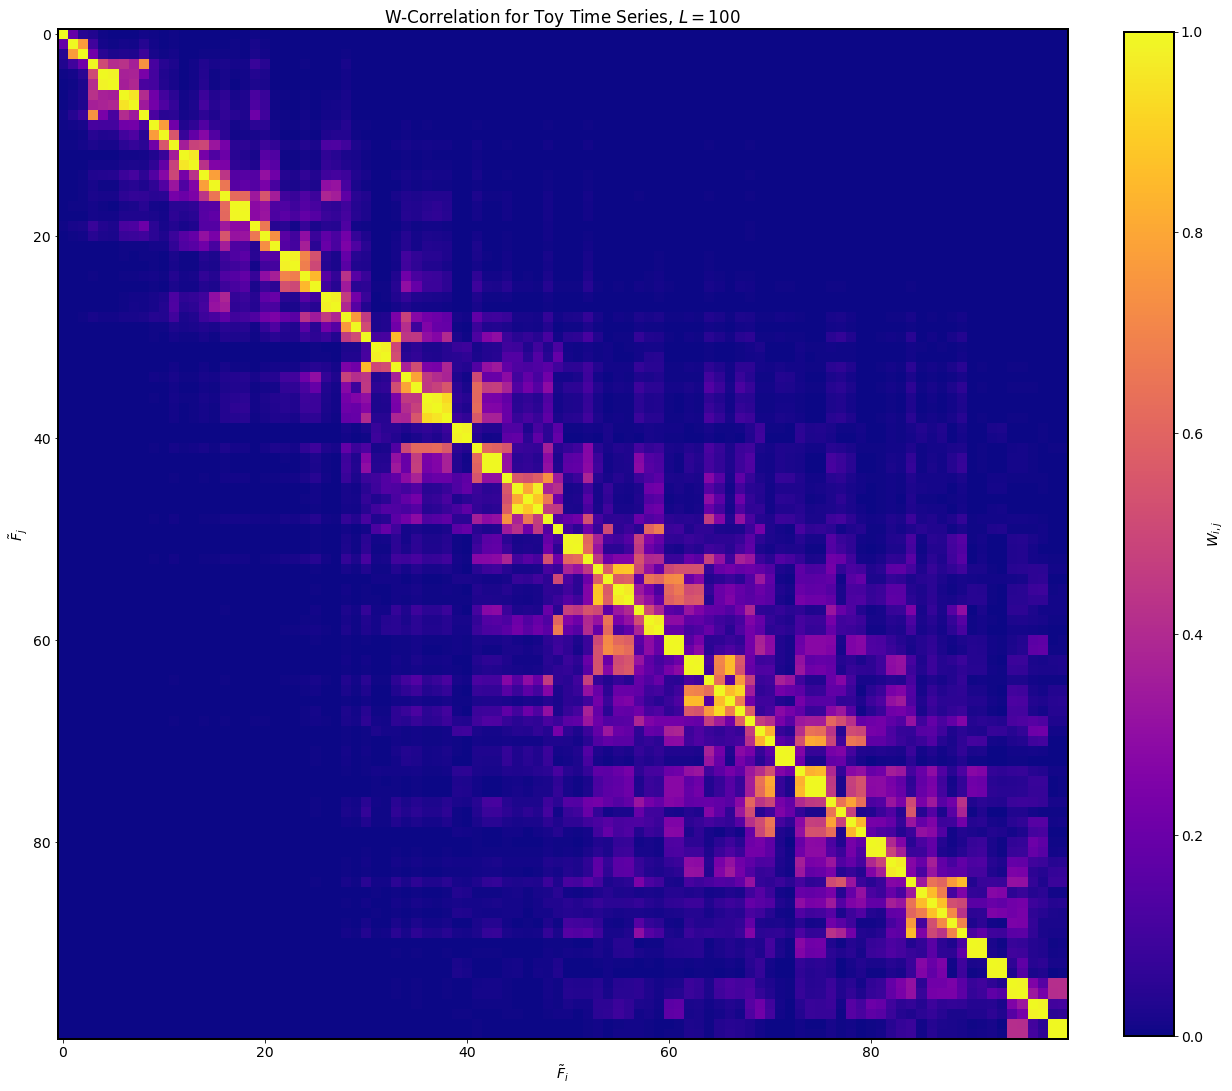

In [44]:
F_ssa_L100.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=100$")

# Whole column

In [52]:
temp_df=pd.DataFrame(x_user,columns=featurename_user)
temp_col=temp_df.iloc[:,1]
temp_col=temp_col.fillna(0)

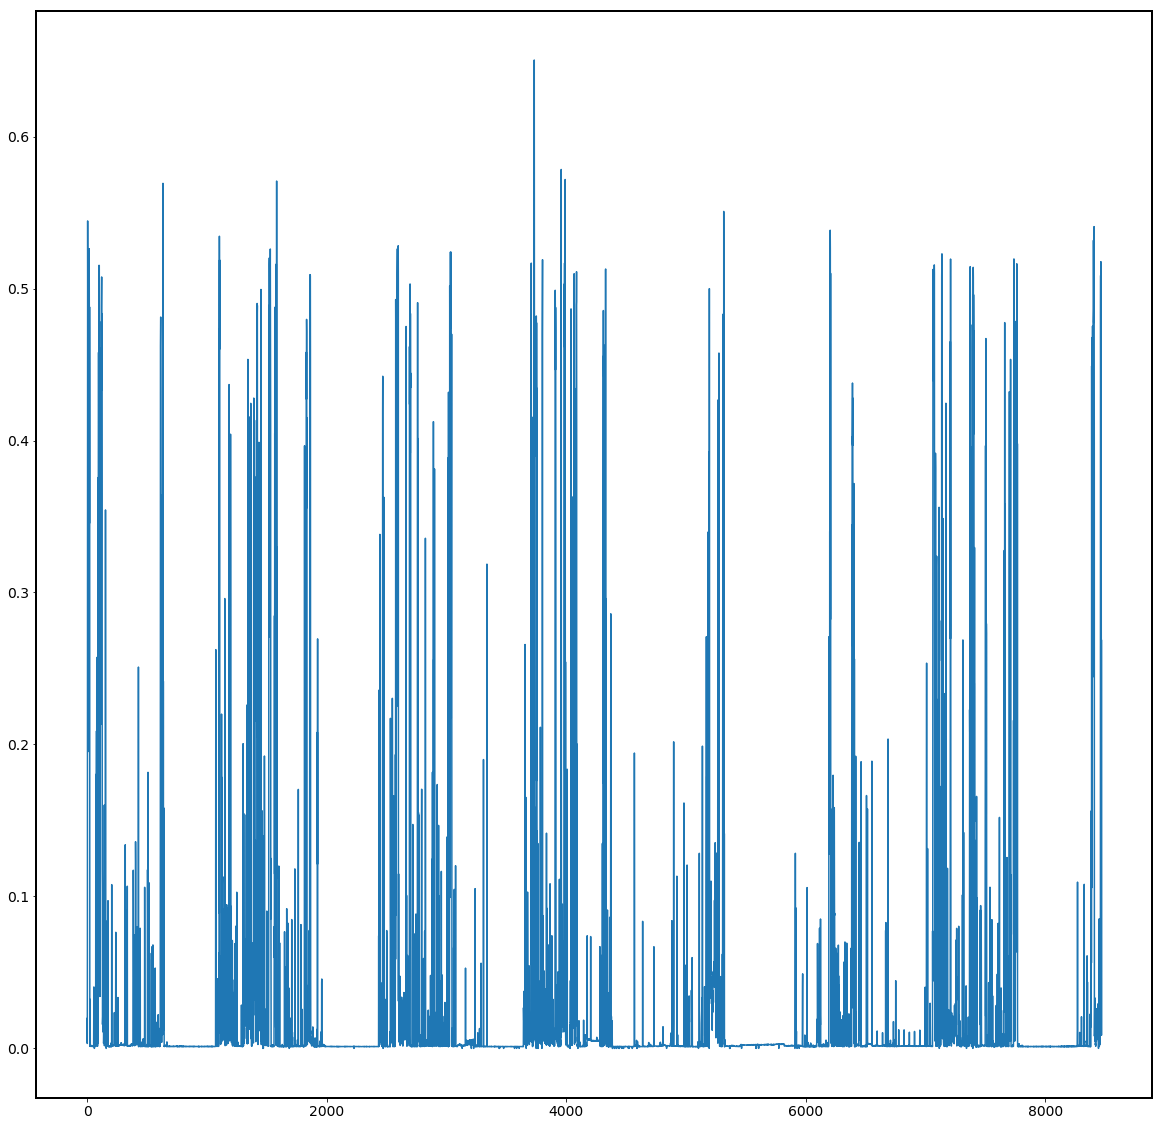

In [53]:
plt.plot(temp_col)

In [54]:
length=4000
window=500
F_ssa_L500=SSA(temp_col,window)

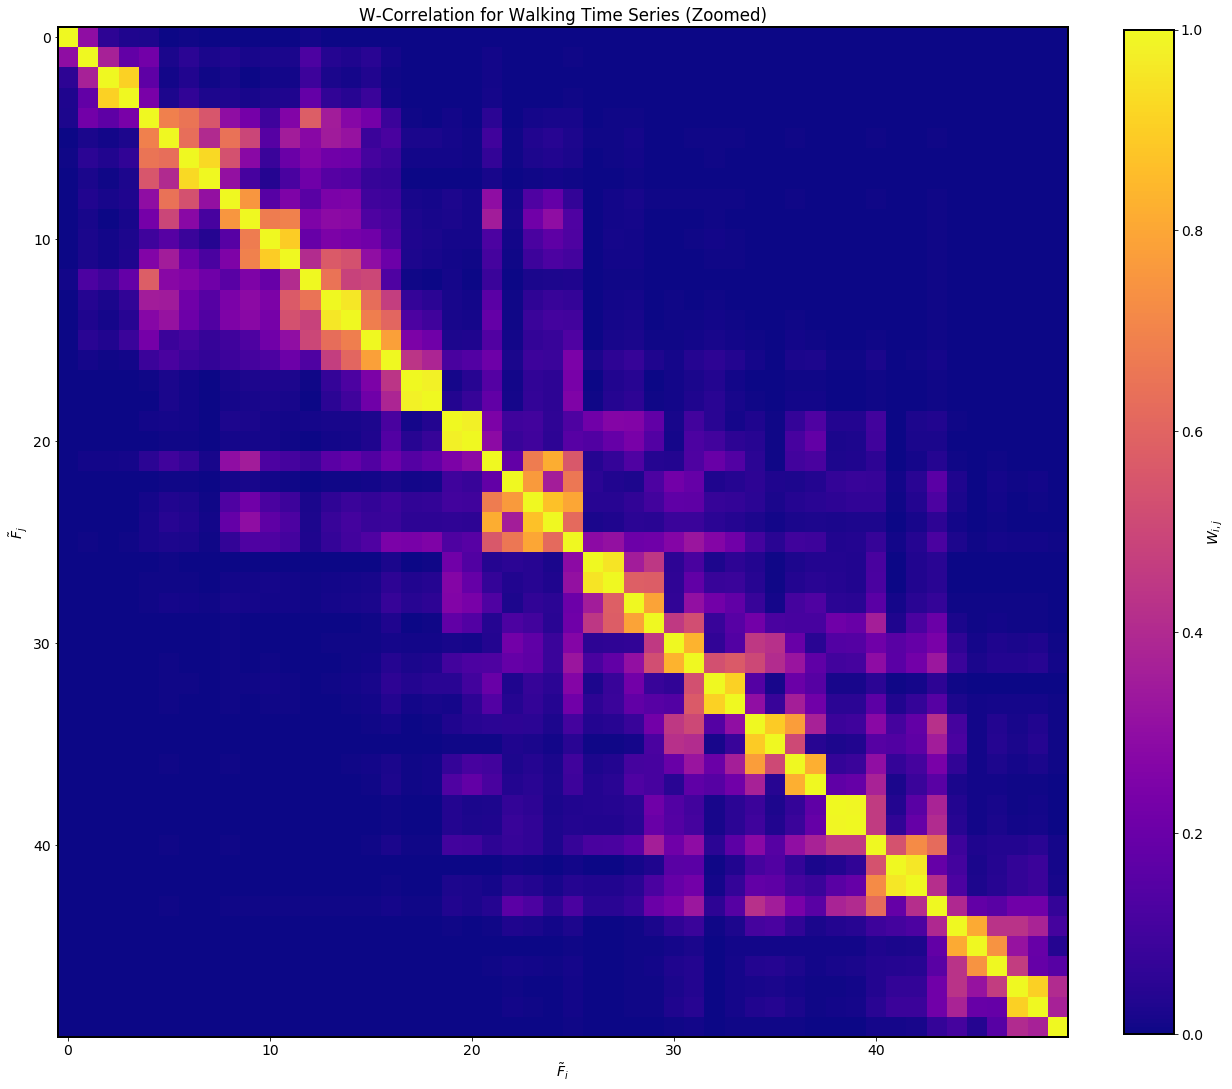

In [55]:
F_ssa_L500.plot_wcorr(max=49)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

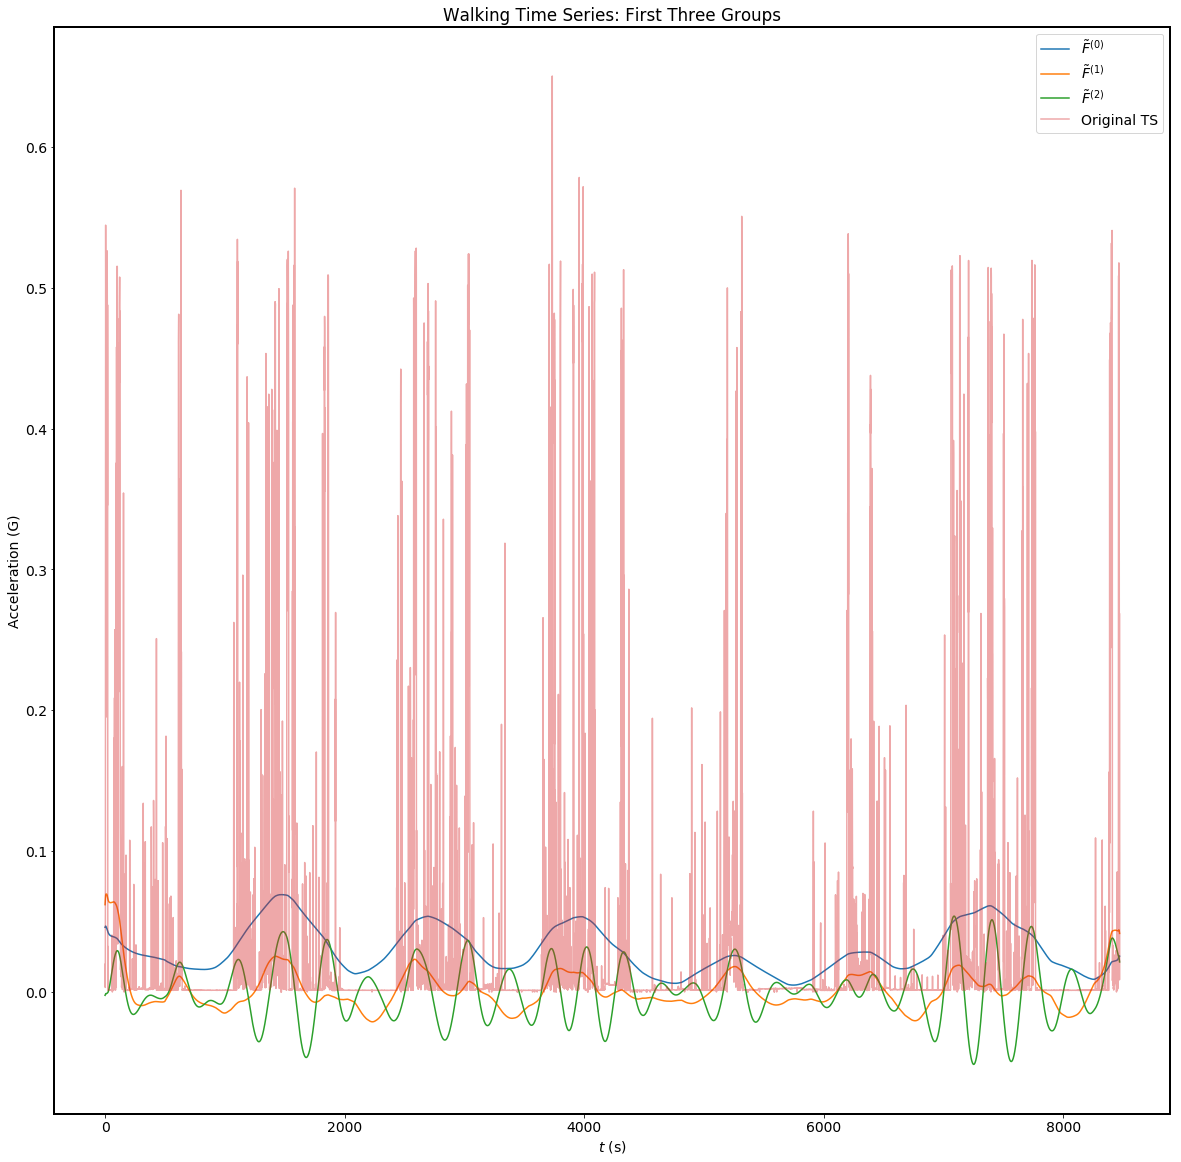

In [63]:
F_ssa_L500.reconstruct(0).plot()
F_ssa_L500.reconstruct([1]).plot()
F_ssa_L500.reconstruct([2,3]).plot()
F_ssa_L500.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

(0, 500)

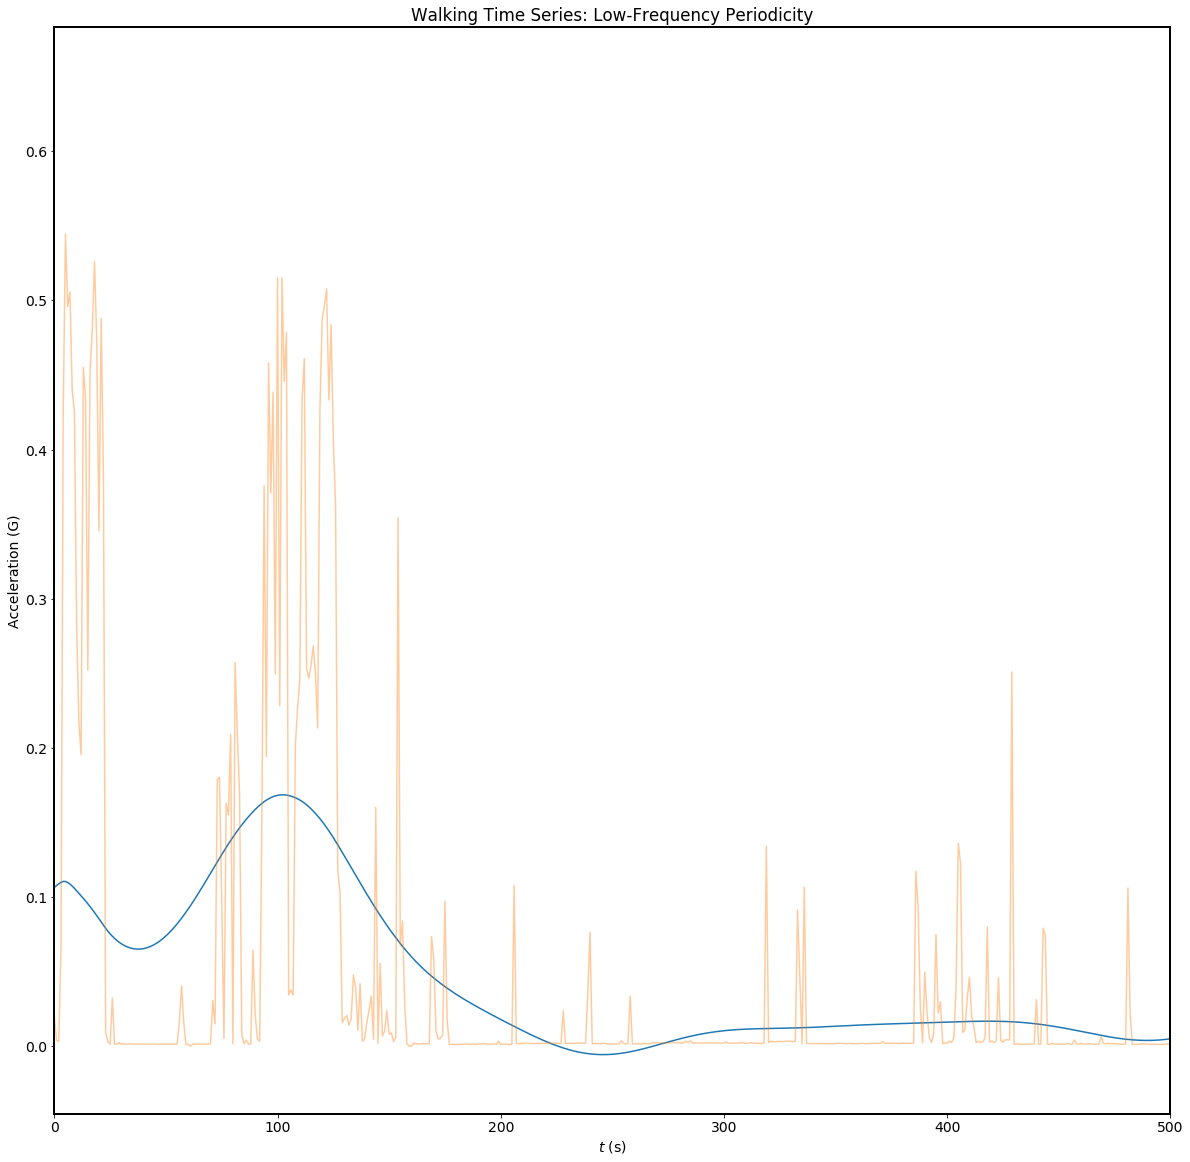

In [61]:
F_ssa_L500.reconstruct(slice(0,5)).plot()
F_ssa_L500.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Low-Frequency Periodicity")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(0,500)
# plt.ylim(0, 2.5);

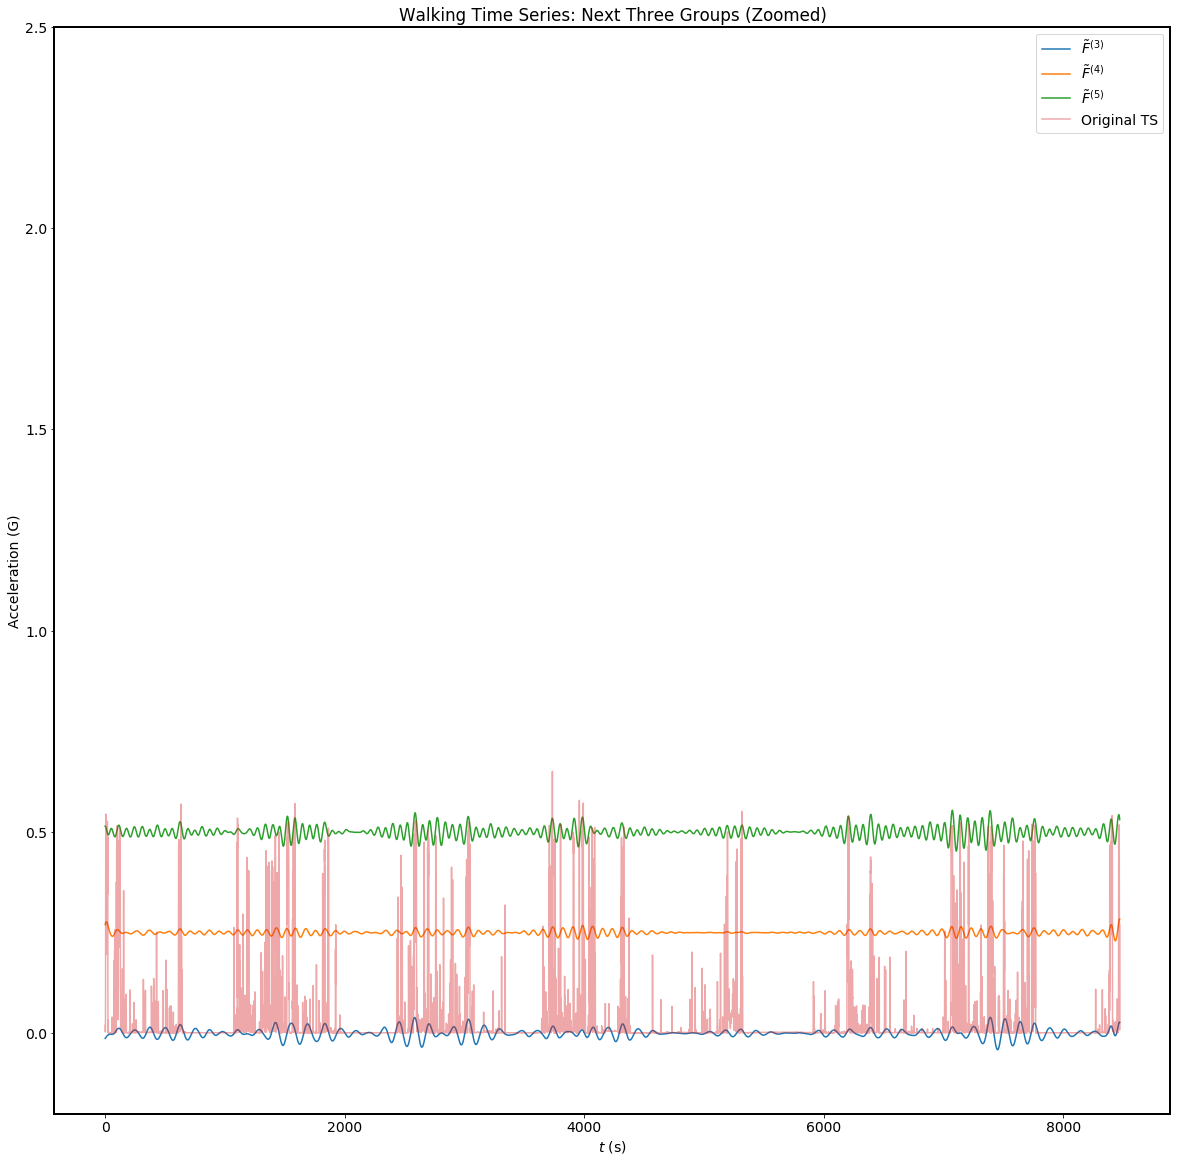

In [66]:
F_ssa_L500.reconstruct([6,7]).plot()
(F_ssa_L500.reconstruct([8]) + 0.25).plot() # Note: adding 0.25 to the series is for visualisation purposes only!
(F_ssa_L500.reconstruct([9,10,11]) + 0.5).plot() # Note: adding 0.5 to the series is for visualisation purposes only!
F_ssa_L500.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Next Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
# plt.xlim(0,500)
plt.ylim(-0.2, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

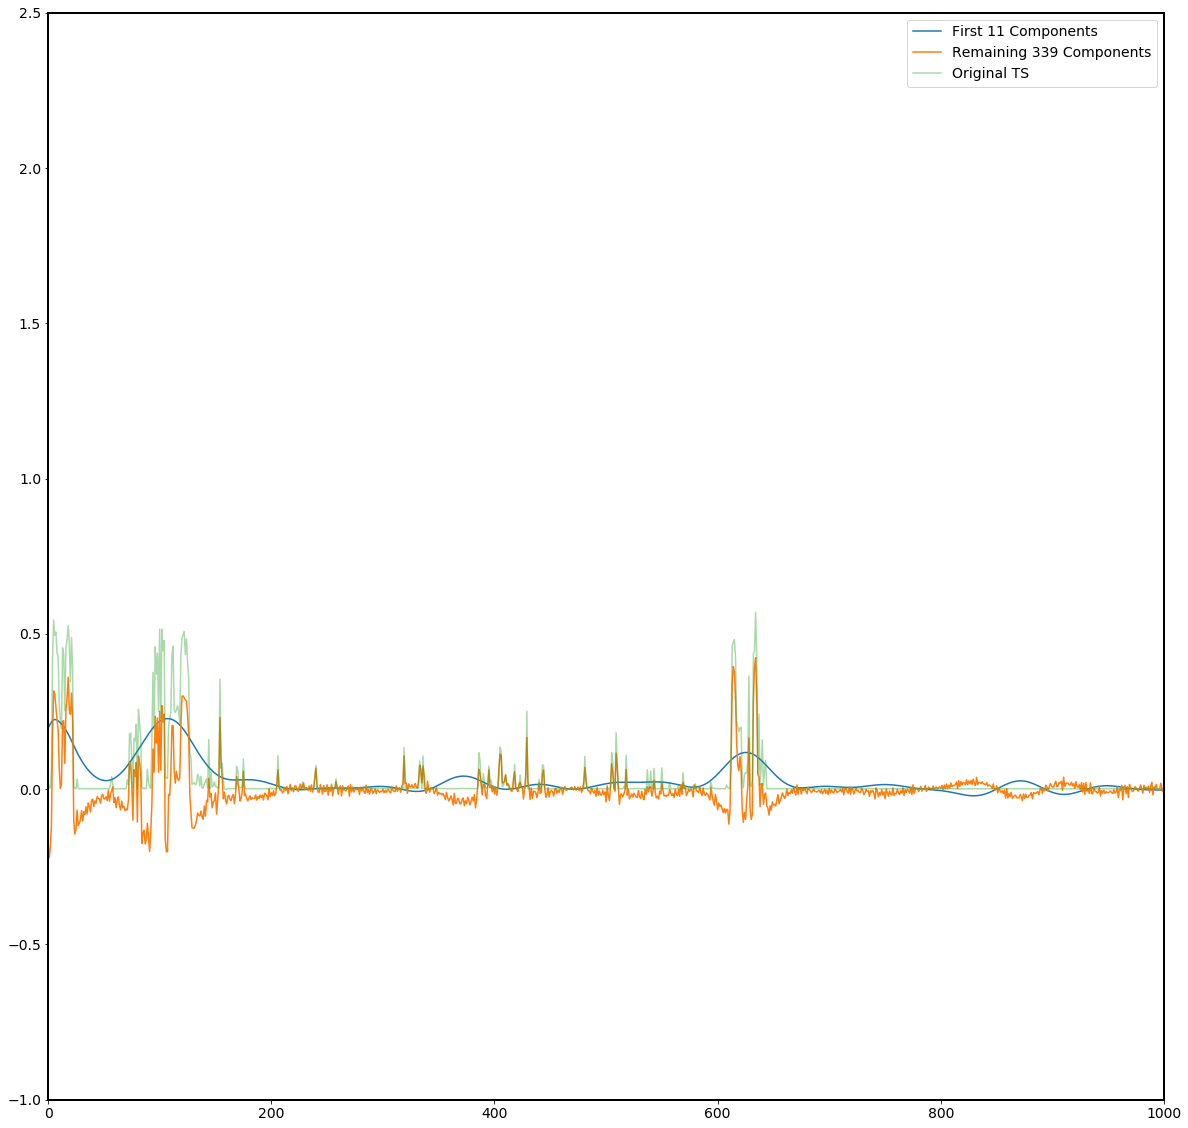

In [68]:
F_ssa_L500.reconstruct(slice(0,11)).plot()
F_ssa_L500.reconstruct(slice(11,350)).plot()
F_ssa_L500.orig_TS.plot(alpha=0.4)
plt.ylim(-1, 2.5)
plt.xlim(0,1000)
plt.legend(["First 11 Components", "Remaining 339 Components", "Original TS"])